# Installation #

The following code installs all packages required for the session. [AnyMOD.jl](https://github.com/leonardgoeke/AnyMOD.jl) is a framework for energy system modeling, and [HiGHS](https://highs.dev/) is an open-source solver for optimization problems. The other packages are for plotting and exporting results. The following code only needs to be executed once and can take a long time. Therefore, we recommend to run it **before the workshop**.  

In [2]:
using Pkg 
Pkg.add(url="https://github.com/leonardgoeke/AnyMOD.jl", rev = "dev")
Pkg.add("HiGHS")
Pkg.add("CairoMakie")
Pkg.add("Colors")
Pkg.add("CSV")

    Updating git-repo `https://github.com/leonardgoeke/AnyMOD.jl`
   Resolving package versions...
    Updating `C:\Git\NextGen_stochasticModeling\Project.toml`
  [16ed6a40] + AnyMOD v0.2.0 `https://github.com/leonardgoeke/AnyMOD.jl#dev`
    Updating `C:\Git\NextGen_stochasticModeling\Manifest.toml`
  [16ed6a40] + AnyMOD v0.2.0 `https://github.com/leonardgoeke/AnyMOD.jl#dev`
  [ec485272] + ArnoldiMethod v0.4.0
  [bf4720bc] + AssetRegistry v0.1.0
  [6e4b80f9] + BenchmarkTools v1.5.0
  [9e28174c] + BinDeps v1.0.2
⌃ [ad839575] + Blink v0.12.5
  [336ed68f] + CSV v0.10.14
  [324d7699] + CategoricalArrays v0.10.8
  [523fee87] + CodecBzip2 v0.8.4
  [944b1d66] + CodecZlib v0.7.6
  [35d6a980] + ColorSchemes v3.26.0
  [3da002f7] + ColorTypes v0.11.5
  [c3611d14] + ColorVectorSpace v0.10.0
  [5ae59095] + Colors v0.12.11
  [bbf7d656] + CommonSubexpressions v0.3.1
  [34da2185] + Compat v4.16.0
  [a8cc5b0e] + Crayons v4.1.1
  [9a962f9c] + DataAPI v1.16.0
  [a93c6f00] + DataFrames v1.6.1
  [864edb3b]

After installation, the packages must be imported. In addition, we include a script defining several functions that are written explicitly for this training session. This step is necessary each time you re-start this script.

In [3]:
using HiGHS, AnyMOD, CairoMakie, Colors, CSV
include("functions.jl")

stackedBarCosts (generic function with 1 method)

# Fundamentals of energy system **planning** models #

Energy planning models decide on the capacity investment and the operation of capacities to satisfy a fixed final energy demand. Typically, and also in our case, models are formulated as linear optimization problems minimizing the total system costs.

Below, we write the resulting optimization problem. *x* is the vector of capacity variables, and *y* is the vector of operational variables. In the objective function, the vectors *c* and *d* assign costs to these decision variables. For instance, *c* would reflect the investment costs of a technology and *d* include the costs of unmet demand.

![Optimization problem](figures/optProblem.svg)

The first constraint restricts only the capacity variables. It could, for example, include a limit on the installed capacity of wind turbines. The second constraint reflects operational restrictions, for instance, that the installed capacity limits the generation of each technology or that net generation must cover demand in each time step.

The figures below show the overall matrix structure of the resulting optimization problem. Each row in the matrix corresponds to a single constraint, and each column to a single variable.

<img src="figures/matrix1.png" alt="drawing" width="600"/>

The grey part in the matrix corresponds to the expansion planning problem and does not include any operational variables. The orange part is the operational problem, including capacity restrictions that connect capacity and operational variables and other constraints that only concern operational variables, like the energy or storage balance.

<img src="figures/matrix2.png" alt="drawing" width="600"/>

# Capacity planning for a base case of climate data # 

As a first step, we will create and solve a standard energy planning using input data from an average climate year. The modelled country is Uruguay and the available technologies to satisfy electricity demand are wind and hydro power with storage. For an in-depth documentation of the modeling framework and functions called below, see the [AnyMOD documentation](https://leonardgoeke.github.io/AnyMOD.jl/stable/).

<span style="color:red">**Disclaimers**</span>
1. This training session uses the latest development version of the [AnyMOD.jl](https://github.com/leonardgoeke/AnyMOD.jl) package. The documentation linked above is so far limited to the main branch. This documentation is still valid and helpful in understanding the general structure and workflow of the tool. Still, it does not yet include documentation of some of the features used in this session, such as the stochastic optimization introduced later.
2. The purpose of the model example is to introduce certain concepts and not to perform realistic modeling. Not only is the model itself highly stylized, but some of the climate-related input data we will use later is not physical; instead, we obtained it by scaling existing data to achieve a desired effect.

In [4]:
# dataframe to gather results throughout the session
allRes_df = DataFrame(scenario = String[], variable = String[], capacity = Float64[])

# inputs folders
inDet_arr = ["general_inputs", "timeSeries_inputs/base"]

# model initialization and creation
base_m = anyModel(inDet_arr, "results", objName = "base", supTsLvl = 1, frsLvl = 0)
createOptModel!(base_m)
setObjective!(:cost, base_m)

# solving the model using JuMP functions (https://github.com/jump-dev/JuMP.jl)
set_optimizer(base_m.optModel, HiGHS.Optimizer)
optimize!(base_m.optModel)

# get detailed dispatch results
reportTimeSeries(:electricity, base_m)

# get overall results
resDet_df =  reportResults(:summary, base_m, rtnOpt = (:csvDf,:csv))

# get capacity results and add to overall dataframe
capaDet_df = filterCapacity(resDet_df, "base")
append!(allRes_df, capaDet_df)

base 00:00:31 - Read-in all set files
base 00:00:57 - Read-in all parameter files
base 00:00:57 - Read-in all set and parameter files - No errors and 3 warning(s) encountered. Wrote reporting_base_202409211651.csv for details! 
base 00:01:05 - Created all mappings among sets
base 00:01:12 - Assigned parameter data to model parts
base 00:01:15 - Prepared creation of optimzation model - No errors and 3 warning(s) encountered. Wrote reporting_base_202409211651.csv for details! 
base 00:02:48 - Created all variables and prepared constraints for technology wind
base 00:03:08 - Created all variables and prepared constraints for technology hydro
base 00:03:09 - Created variables and constraints for all technologies - No errors and 3 warning(s) encountered. Wrote reporting_base_202409211651.csv for details! 
base 00:03:12 - Created variables and constraints for all exchange - No errors and 3 warning(s) encountered. Wrote reporting_base_202409211651.csv for details! 
base 00:03:12 - Created var

Row,scenario,variable,capacity
,String,String,Float64
1,base,hydro pump,2.44331
2,base,hydro size,251.412
3,base,wind,6.64565


To visualize the resulting capacities, we create a radar plot reflecting the three distinct capacity decisions.

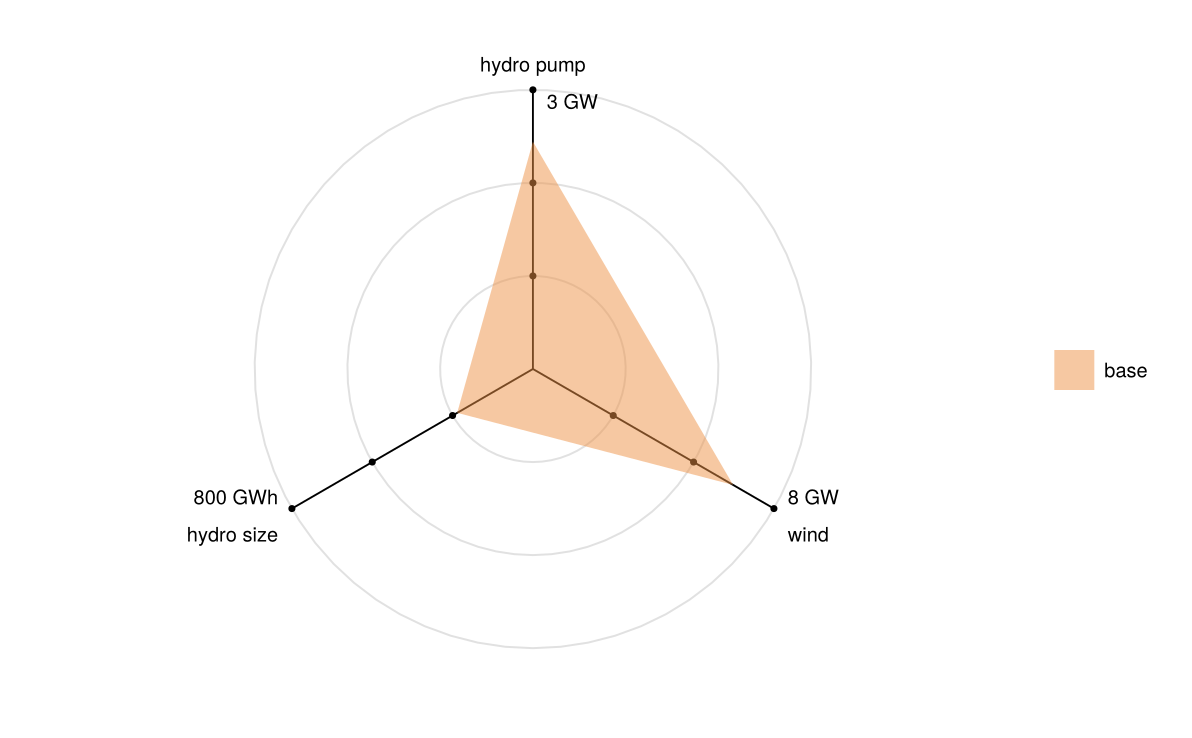

In [5]:
capaRadarPlot_obj, axisCapaRadarPlot_obj = initializeRadar(3, 3, unique(capaDet_df[!,:variable]), ["3 GW","800 GWh","8 GW"], 45.0)
addData!(capaRadarPlot_obj, axisCapaRadarPlot_obj, capaDet_df[!,:capacity], "base", (239/255, 147/255, 71/255), 0.5)
capaRadarPlot_obj

# Capacity planning for extreme years of climate data # 

Since the computation above only uses the base case for climate conditions assuming an average climate year, it cannot be expected to function under more extreme conditions. We rerun the capacity planning model to cover such conditions but not for the base case of climate conditoins. Instead, we perform two runs, the first with higher demand and low wind availability, the second with high demand and low hydro inflows.

In [6]:
for x in ("highDemLowWind", "highDemLowHydro")

    # create and solve deterministic model for reference case
    inDet_arr = ["general_inputs", "timeSeries_inputs/" * x]

    # create and solve model for base case
    ext_m = anyModel(inDet_arr, "results", objName = x, supTsLvl = 1, frsLvl = 0)
    createOptModel!(ext_m)
    setObjective!(:cost, ext_m)

    set_optimizer(ext_m.optModel, HiGHS.Optimizer)
    optimize!(ext_m.optModel)

    # get overall results
    resExt_df =  reportResults(:summary, ext_m, rtnOpt = (:csvDf,:csv))

    # get capacity results and add to overall dataframe
    capaExt_df = filterCapacity(resExt_df, x)
    append!(allRes_df, capaExt_df)

    # add data to rader plot
    if x == "highDemLowHydro"
        addData!(capaRadarPlot_obj, axisCapaRadarPlot_obj, capaExt_df[!,:capacity], x, (103/255,130/255,228/255), 0.3)
    else
        addData!(capaRadarPlot_obj, axisCapaRadarPlot_obj, capaExt_df[!,:capacity], x, (179/255, 236/255, 116/255), 0.3)
    end

end

highDemLowWind 00:00:00 - Read-in all set files
highDemLowWind 00:00:02 - Read-in all parameter files
highDemLowWind 00:00:02 - Read-in all set and parameter files - No errors and 3 warning(s) encountered. Wrote reporting_highDemLowWind_202409211700.csv for details! 
highDemLowWind 00:00:02 - Created all mappings among sets
highDemLowWind 00:00:02 - Assigned parameter data to model parts
highDemLowWind 00:00:02 - Prepared creation of optimzation model - No errors and 3 warning(s) encountered. Wrote reporting_highDemLowWind_202409211700.csv for details! 
highDemLowWind 00:00:03 - Created all variables and prepared constraints for technology wind
highDemLowWind 00:00:04 - Created all variables and prepared constraints for technology hydro
highDemLowWind 00:00:04 - Created variables and constraints for all technologies - No errors and 3 warning(s) encountered. Wrote reporting_highDemLowWind_202409211700.csv for details! 
highDemLowWind 00:00:04 - Created variables and constraints for all 

Within the loop, we added the new results to our radar plot. The results show that we get very different results, and the climate conditions substantially impact system design.

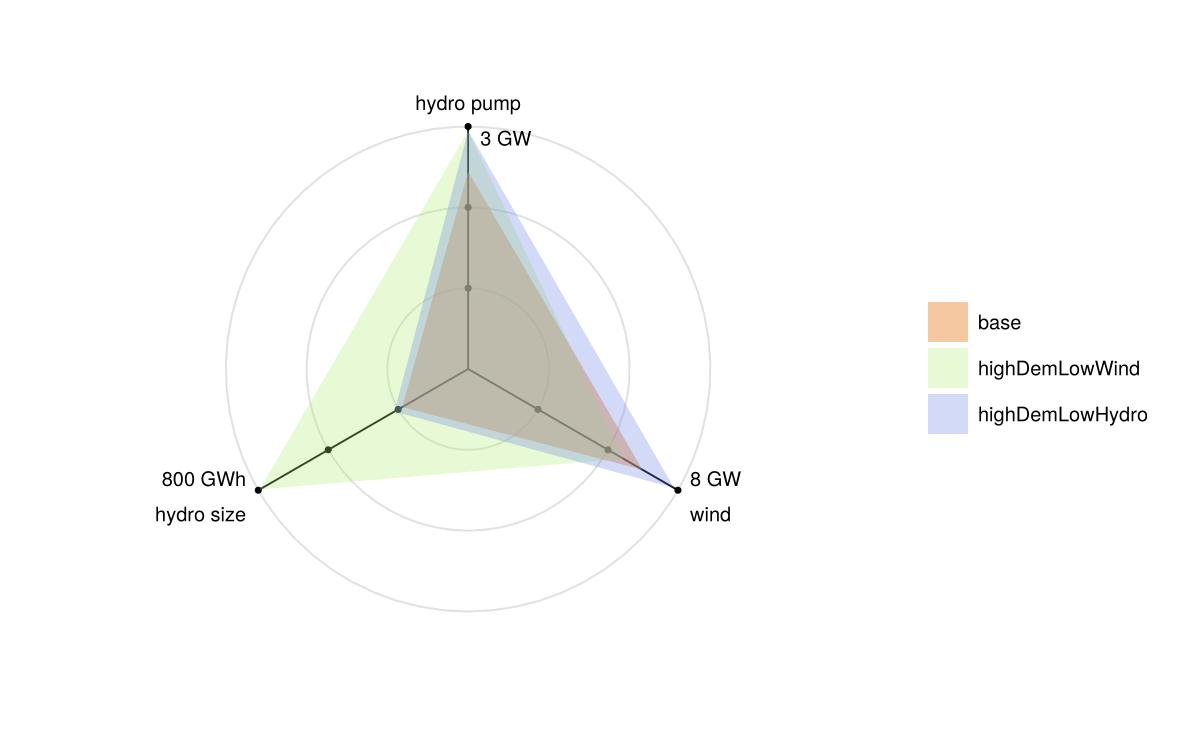

In [7]:
capaRadarPlot_obj

# System design based on all scenarios using the convex hull # 

We have now obtained three different system designs by solving the same model for the three years of climate inputs. Yet, the system planning aims to identify a single design for all climate conditions. 

One option to get a single design that works well for each of the three years is for each capacity decision to take the maximum value from the three designs. In geometrical terms, this approach uses the convex hull of all our existing solutions. Below, we compute this solution and add it to the radar plot.

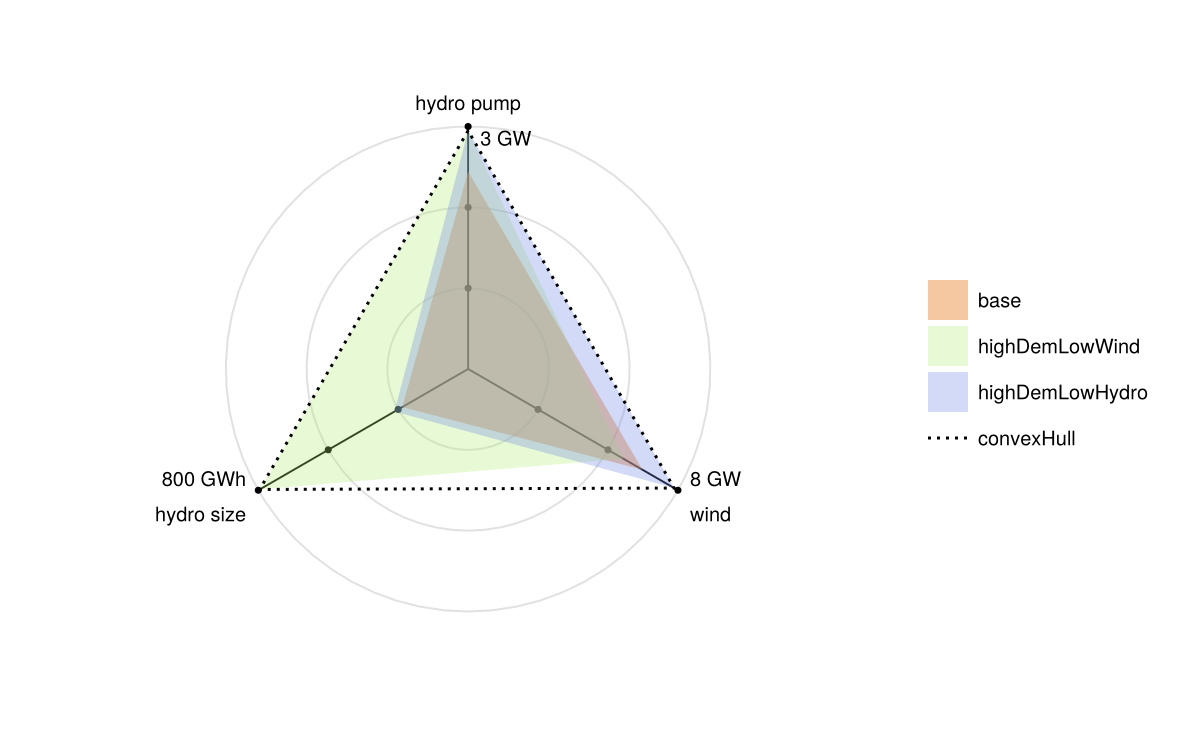

In [8]:
convexHull_df = combine(x -> (capacity = maximum(x.capacity), scenario = "convexHull"), groupby(allRes_df, :variable))
append!(allRes_df, convexHull_df)
addData!(capaRadarPlot_obj, axisCapaRadarPlot_obj, convexHull_df[!,:capacity], "convexHull", (0/255, 0/255, 0/255), 0.0, linestyle = :dot)
capaRadarPlot_obj

# System design based on stochastic optimization # 

So far, we have solved the three models visualized below, each consisting of an identical expansion part but a different dispatch part since we used different climate data, either for a base case or one of the two extreme cases. As a result, we got three different capacity setups, and each setup was planned with certain information regarding the climate data. Thus, each model was **deterministic**. 

<img src="figures/allMatrix.png" alt="drawing" width="1000"/>

However, capacity planning under different climate conditions is a stochastic problem since we need to make one capacity decision without knowing the climate conditions. Accordingly, we can also write the planning problem as a stochastic optimization problem that makes capacity decisions accounting not only for a single set of climate data but all three sets. In the stochastic problem, each set of climate data represents one scenario, and each scenario has a probability that is used to weigh its operational costs in the objective function. The resulting problem matrix is presented in the figure below.

<img src="figures/stochMatrix.png" alt="drawing" width="600"/>

In the code below, we create and solve this stochastic problem. The most important difference is that now all time-series files are input, and we must add files to define the scenarios and their probability. 

In [13]:
# define input folder (all time-series data now and scenario definition)
inStoch_arr = ["general_inputs", "timeSeries_inputs", "scenario_inputs"]

# create and solve stochastic model
stoch_m = anyModel(inStoch_arr, "results", objName = "stochastic", supTsLvl = 1, frsLvl = 0)
createOptModel!(stoch_m)
setObjective!(:cost, stoch_m)

set_optimizer(stoch_m.optModel, HiGHS.Optimizer)
optimize!(stoch_m.optModel)

# get costs
cost_df = getCosts(stoch_m, "stochastic")

# get overall results
resStoch_df =  reportResults(:summary, stoch_m, rtnOpt = (:csvDf,:csv))

# get capacity results and add to overall dataframe
capaStoch_df = filterCapacity(resStoch_df, "stochastic")
append!(allRes_df, capaStoch_df)

stochastic 00:00:00 - Read-in all set files
stochastic 00:00:24 - Read-in all parameter files
stochastic 00:00:24 - Read-in all set and parameter files - No errors and 0 warning(s) encountered. 
stochastic 00:00:24 - Created all mappings among sets
stochastic 00:00:25 - Assigned parameter data to model parts
stochastic 00:00:25 - Prepared creation of optimzation model - No errors and 0 warning(s) encountered. Wrote reporting_stochastic_202409221652.csv for details! 
stochastic 00:00:27 - Created all variables and prepared constraints for technology wind
stochastic 00:00:37 - Created all variables and prepared constraints for technology hydro
stochastic 00:00:42 - Created variables and constraints for all technologies - No errors and 0 warning(s) encountered. Wrote reporting_stochastic_202409221652.csv for details! 
stochastic 00:00:42 - Created variables and constraints for all exchange - No errors and 0 warning(s) encountered. Wrote reporting_stochastic_202409221652.csv for details! 


Row,scenario,variable,capacity
,String,String,Float64
1,base,hydro pump,2.44331
2,base,hydro size,251.412
3,base,wind,6.64565
4,highDemLowWind,hydro pump,2.94632
5,highDemLowWind,hydro size,794.675
6,highDemLowWind,wind,5.91841
7,highDemLowHydro,hydro pump,2.94848
8,highDemLowHydro,hydro size,280.763
9,highDemLowHydro,wind,7.85446


Again, we can add the new results to our radar plot. We see that the method requires less capacity then the convex hull.

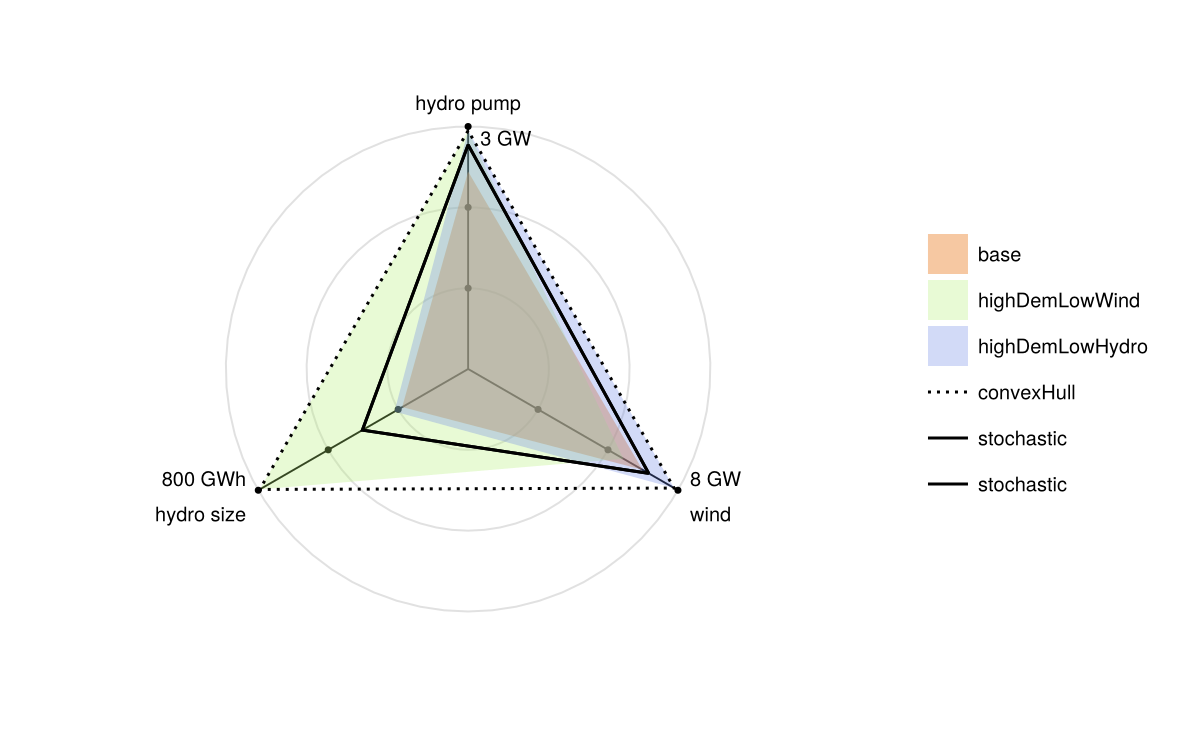

In [11]:
addData!(capaRadarPlot_obj, axisCapaRadarPlot_obj, capaStoch_df[!,:capacity], "stochastic", (0/255, 0/255, 0/255), 0.0)
capaRadarPlot_obj

# Evaluate true costs of all capacity setups #

While the stochastic optimization approach is the most suitable, it is also the most difficult computationally. Including all climate conditions into one optimization problem creates a much bigger problem than only representing a single set of climate conditions. As a result, solving larger models is challenging and often requires [special solution algorithms](https://www.sciencedirect.com/science/article/pii/S0377221724000353).

However, testing the quality of the other four non-stochastic solutions using the stochastic model can be done more easily. For this purpose, we fix the capacity variables, such as the convex hull design, and only run the operational part of the stochastic problem, which is much easier to solve. The code below carries out this task.

In [15]:
# run stochastic model fixing the capacities to previous results
for scr in ("base", "highDemLowHydro", "highDemLowWind", "convexHull")
    append!(cost_df, runStochFixed(allRes_df, scr))
end

stochasticFixed_base 00:00:00 - Read-in all set files
stochasticFixed_base 00:00:04 - Read-in all parameter files
stochasticFixed_base 00:00:04 - Read-in all set and parameter files - No errors and 0 warning(s) encountered. 
stochasticFixed_base 00:00:04 - Created all mappings among sets
stochasticFixed_base 00:00:04 - Assigned parameter data to model parts
stochasticFixed_base 00:00:04 - Prepared creation of optimzation model - No errors and 0 warning(s) encountered. Wrote reporting_stochasticFixed_base_202409221704.csv for details! 
stochasticFixed_base 00:00:05 - Created all variables and prepared constraints for technology wind
stochasticFixed_base 00:00:07 - Created all variables and prepared constraints for technology hydro
stochasticFixed_base 00:00:08 - Created variables and constraints for all technologies - No errors and 0 warning(s) encountered. Wrote reporting_stochasticFixed_base_202409221704.csv for details! 
stochasticFixed_base 00:00:08 - Created variables and constrain

Once we solve the stochastic problem fixed to the different capacity setups, we can compare the true costs of each solution.

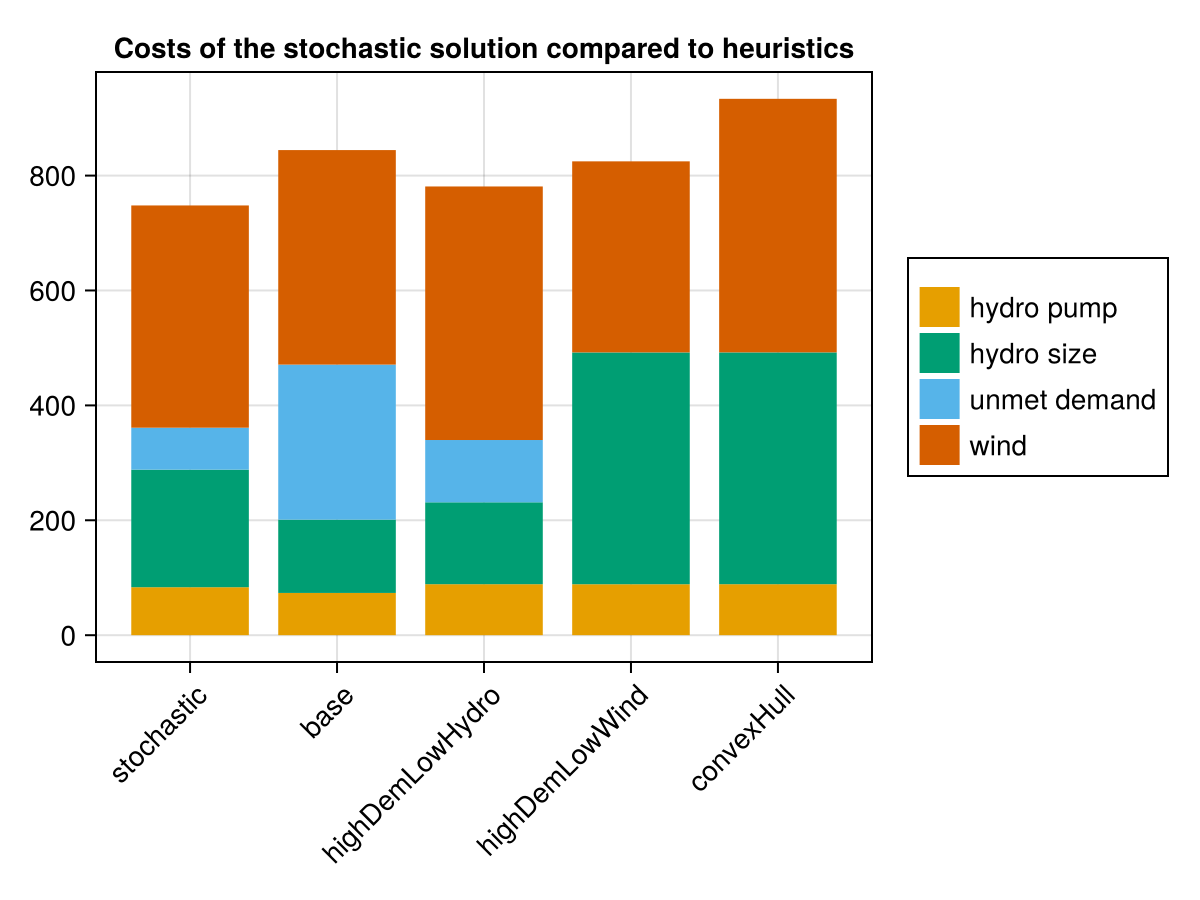

In [16]:
# create bar chart to compare results
stackedBarCosts(cost_df)


Since the stochastic system design was computed using the stochastic approach, it will always have the smallest costs and is a lower bound for all other designs. Note that this design still has unmet demand because it is cost-optimal. For the assumed costs of unmet demand and probabilities of the extreme scenarios, it is more cost-efficient to accept some unmet demand under extreme but rare conditions rather than investing in more capacities. The expected share of unmet demand is 0.0013% percent in our example.

The other designs all have higher costs. In the base and low hydro case, capacity investment is insufficient. As a result, unmet demand is above the cost-optimal level. For the low wind and convex hull design, the system is over-engineered when factoring in the low probability of the extreme cases.

In conclusion, the stochastic optimization approach is the most appropriate but challenging to solve for large models. How close the other heuristic designs are to the stochastic solution depends on the specific problem and has not been studied yet. It is important to point out that even when deviating from our example and not allowing for any unmet demand, the stochastic design will outperform the heuristics and can lead to substantially lower costs.

Finally, it should be noted that although the present stochastic approach is more accurate than deterministic planning, it still makes some critical assumptions that do not hold in reality.
1. There is **perfect information about weather conditions** within each climate case scenario. As a result, the model makes dispatch decisions with perfect foresight regarding weather conditions for an entire year. In reality, meaningful weather forecasts are only available a few weeks into the future.
2. Since the stochastic approach treats each scenario of climate inputs separately, it assumes the same **climate conditions are indefinitely repeating**. However, in reality, there are consecutive years with different weather conditions. For instance, a low wind year can follow a low hydro year. The introduced simple stochastic approach cannot account for this.
3. The approach assumes that the defined **climate scenarios cover all critical conditions**. In practice, this is difficult since the criticality of climate conditions heavily depends on the system design, so they are in fact a function of the model results.